In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content' # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path)

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 9143, done.
remote: Total 9143 (delta 0), reused 0 (delta 0), pack-reused 9143
Receiving objects: 100% (9143/9143), 9.72 MiB | 26.84 MiB/s, done.
Resolving deltas: 100% (6349/6349), done.


In [ ]:
!pip install -qr /content/yolov5/requirements.txt  # install dependencies

     |████████████████████████████████| 636 kB 5.0 MB/s 


In [ ]:
!pip install albumentations==1.0.3

     |████████████████████████████████| 98 kB 3.6 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (CPU)


In [ ]:
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Make temp folder for reduced dataset
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images_2k/
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/annotations_2k/

In [ ]:
# Set size of dataset and copy to new images folder
old_dir = "/content/drive/MyDrive/OCR Project(SMU)/images_coloured/"
new_dir = "/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images_2k/"

# transfer 1800 coloured
num = 0
for file in sorted(os.listdir(old_dir)): 
    shutil.copy(old_dir+file, new_dir+file)
    num+=1
    if num == 1800:
        break

# transfer 200 greyscale
num = 0
for file in sorted(os.listdir(old_dir), reverse=True): 
    shutil.copy(old_dir+file, new_dir+file)
    num+=1
    if num == 200:
        break


In [ ]:
# Set size of dataset and copy to new annotations folder
old_dir = "/content/drive/MyDrive/OCR Project(SMU)/Annotations_corrected/"
new_dir = "/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/annotations_2k/"

# transfer 1800 coloured
num = 0
for file in sorted(os.listdir(old_dir)): 
    shutil.copy(old_dir+file, new_dir+file)
    num+=1
    if num == 1800:
        break

# transfer 200 greyscale
num = 0
for file in sorted(os.listdir(old_dir), reverse=True): 
    shutil.copy(old_dir+file, new_dir+file)
    num+=1
    if num == 200:
        break


In [ ]:
# Read 20000 images and annotations
# annotations = [os.path.join('/content/drive/MyDrive/OCR Project(SMU)/Annotations_corrected/', file) for file in os.listdir('/content/drive/MyDrive/OCR Project(SMU)/Annotations_corrected/')]
# images = [os.path.join('/content/drive/MyDrive/OCR Project(SMU)/images_coloured/', file) for file in os.listdir('/content/drive/MyDrive/OCR Project(SMU)/images_coloured/')]

# Read 2000 images & annotations 
annotations = [os.path.join('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/annotations_2k/', file) for file in os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/annotations_2k/')]
images = [os.path.join('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images_2k/', file) for file in os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images_2k/')]

annotations.sort()
images.sort()

In [ ]:
print(len(annotations))
print(len(images))
print(annotations)
print(images)

NameError: ignored

[['36', '0.354688', '0.829687', '0.159375', '0.115625'], ['39', '0.845313', '0.490625', '0.184375', '0.125000'], ['36', '0.531250', '0.420312', '0.150000', '0.178125'], ['18', '0.398438', '0.201562', '0.178125', '0.103125'], ['4', '0.762500', '0.870313', '0.112500', '0.190625'], ['32', '0.265625', '0.548438', '0.175000', '0.140625'], ['33', '0.676562', '0.117188', '0.159375', '0.165625'], ['38', '0.115625', '0.281250', '0.137500', '0.137500'], ['40', '0.785937', '0.639062', '0.165625', '0.121875'], ['31', '0.073438', '0.540625', '0.121875', '0.093750'], ['1', '0.829687', '0.314063', '0.146875', '0.146875'], ['0', '0.592187', '0.804688', '0.184375', '0.128125'], ['39', '0.093750', '0.901563', '0.187500', '0.178125'], ['29', '0.245312', '0.298438', '0.096875', '0.103125'], ['25', '0.081250', '0.112500', '0.125000', '0.125000'], ['14', '0.392188', '0.720313', '0.146875', '0.090625']]


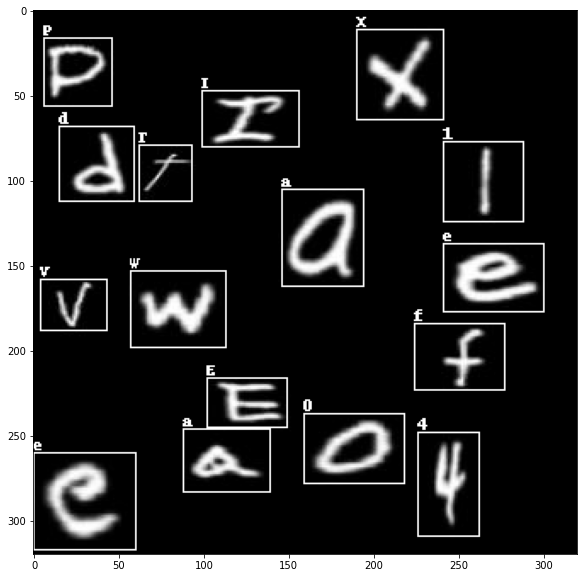

In [ ]:
random.seed(2)

class_id_to_name_mapping = {}
test = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
for i in range(len(test)):
  class_id_to_name_mapping[i] = test[i]

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    plt.rcParams["figure.figsize"] = (10,10)
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    print(annotation_list)
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Load the image
image_file = annotation_file.replace("annotations_2k", "images_2k").replace("txt", "jpg")
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# %mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k
%cd /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k
# /content/drive/MyDrive/OCR Project(SMU)/Annotations (txt)
# /content/drive/MyDrive/OCR Project(SMU)/Images

/content/drive/.shortcut-targets-by-id/1WK11nDrpd3xOIA3tsI8W6rYXWXIvlA00/OCR Project(SMU)/emnist_coloured_2k


In [ ]:
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/labels

%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images/train
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images/val
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images/test

%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/labels/train
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/labels/val
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/labels/test

In [ ]:
# Utility function to move images 
def copy_files_to_folder(list_of_files, destination_folder):
    num = 0
    numfiles = len(list_of_files)
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
            num += 1
            if num %100 == 0:
                print(f"{num/numfiles*100}% Progress for {destination_folder}")
        except:
            print(f)
            assert False

# Copy the splits into their folders
copy_files_to_folder(train_images, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train')
copy_files_to_folder(val_images, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/val')
copy_files_to_folder(test_images, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/test')
copy_files_to_folder(train_annotations, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/train')
copy_files_to_folder(val_annotations, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/val')
copy_files_to_folder(test_annotations, '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/test')

6.25% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
12.5% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
18.75% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
25.0% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
31.25% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
37.5% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
43.75% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
50.0% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
56.25% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
62.5% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train
68.75% Progress for /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/train')))
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/val')))
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/test')))
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/train')))
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/val')))
print(len(os.listdir('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/labels/test')))

1600
200
200
1600
200
200


In [ ]:
shutil.copy('/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/emnist_coloured_2k_data.yaml', '/content/yolov5/data')

'/content/yolov5/data/emnist_coloured_2k_data.yaml'

In [ ]:
# Weights & Biases
!pip install wandb --upgrade

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 133 kB 50.3 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 44.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a7dd2dd2707af770eac2dc4c7f6e0449bda6c7612dc36c137f4d8b1accde30b1
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c373658fa1378fdecdabc1f2f8400b939f26c9e4bb9636cb55ff0509c849cd2a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb
# wandb.login()
!wandb login 1752d2f0785658c328f0ed6d6c0bc7debd495d9c

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# import wandb
wandb.init(project="OCR-Project")

wandb: Currently logged in as: lesterye (use `wandb login --relogin` to force relogin)


In [ ]:
# wandb.log({'accuracy': train_acc, 'loss': train_loss})

NameError: ignored

In [ ]:
# wandb.config.dropout = 0.2

In [ ]:
# Tensorboard
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs/train

<IPython.core.display.Javascript object>

In [ ]:
# Train YOLOv5s on EMNIST for 300 epochs
# --workers 8
!python /content/yolov5/train.py --img 320 --cfg /content/yolov5/models/yolov5s.yaml --hyp /content/yolov5/data/hyps/hyp.scratch.yaml --batch 64 --epochs 300 --data /content/yolov5/data/emnist_coloured_2k_data.yaml --weights /content/drive/MyDrive/OCR\ Project\(SMU\)/yolov5s.pt --name /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/yolo_emnist_train_det

wandb: Currently logged in as: lesterye (use `wandb login --relogin` to force relogin)
train: weights=/content/drive/MyDrive/OCR Project(SMU)/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/yolov5/data/emnist_coloured_2k_data.yaml, hyp=/content/yolov5/data/hyps/hyp.scratch.yaml, epochs=300, batch_size=64, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_train_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v5.0-454-g9febea7 torch 1.9.0+cu102 CU

In [ ]:
%mkdir /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_20k/path/to

In [ ]:
# from utils.utils import *; plot_results()
%cd /content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_20k/yolo_emnist_train_det3
from utils.plots import plot_results; plot_results()
plot_results(save_dir='/content/drive/MyDrive/OCR Project(SMU)/runs/train/exp')  # plot results.csv as results.png

[Errno 2] No such file or directory: '/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_20k/yolo_emnist_train_det3'
/content


ModuleNotFoundError: ignored

In [ ]:
!python /content/yolov5/detect.py --source /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/images/test --weights /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/yolo_emnist_train_det3/weights/best.pt --conf 0.25 --name /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/yolo_emnist_detect_det

detect: weights=['/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_train_det3/weights/best.pt'], source=/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_detect_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-454-g9febea7 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 224 layers, 7177972 parameters, 0 gradients, 16.7 GFLOPs
image 1/200 /content/drive/.shortcut-targets-by-id/1WK11nDrpd3xOIA3tsI8W6rYXWXIvlA00/OCR Project(SMU)/emnist_coloured_2k/images/test/000003.jpg: 640x640 1 0, 1 3, 1 5, 1 9, 1 C, 1 G, 2 Os, 2 Us, 1 W, 1 Y, 1 a,

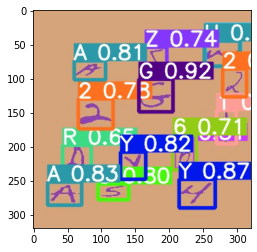

In [ ]:
%matplotlib inline

detections_dir = "/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_detect_det"
detection_images = [os.path.join(detections_dir, file) for file in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [ ]:
# mAP Evaluation
!python /content/drive/MyDrive/OCR\ Project\(SMU\)/test.py --weights /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_20k/yolo_emnist_train_det/weights/best.pt --data /content/yolov5/data/emnist_coloured_20k_data.yaml --task test --name /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_20k/yolo_emnist_mAP_det

Traceback (most recent call last):
  File "/content/drive/MyDrive/OCR Project(SMU)/test.py", line 12, in <module>
    from models.experimental import attempt_load
ModuleNotFoundError: No module named 'models'


In [ ]:
!python /content/yolov5/detect.py --source /content/drive/MyDrive/OCR\ Project\(SMU\)/real_images/rand_3.jpg --weights /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/yolo_emnist_train_det3/weights/best.pt --conf 0.25 --name /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_2k/yolo_emnist_detect_det_real


detect: weights=['/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_train_det3/weights/best.pt'], source=/content/drive/MyDrive/OCR Project(SMU)/real_images/rand_3.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_detect_det_real, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-454-g9febea7 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7177972 parameters, 0 gradients, 16.7 GFLOPs
image 1/1 /content/drive/MyDrive/OCR Project(SMU)/real_images/rand_3.jpg: 544x640 1 7, 1 A, 1 K, 4 Ms, 1 R, 2 Xs, 1 h, 2 ns, 1 t, Done. (0.458s)
Speed: 4.6ms pre-process, 457.5ms inference, 1.8ms NMS per image at shape (1, 3, 640, 640)
Resul

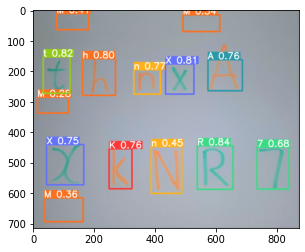

In [ ]:
# random.seed()
%matplotlib inline

detections_dir = "/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_2k/yolo_emnist_detect_det_real4"
detection_images = [os.path.join(detections_dir, file) for file in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))
# plt.rcParams["figure.figsize"] = (150,100)

In [ ]:
!python /content/yolov5/detect.py --source /content/drive/MyDrive/OCR\ Project\(SMU\)/real_images/typing_1.jpg --weights /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_20k/yolo_emnist_train_det2/weights/best.pt --conf 0.25 --name /content/drive/MyDrive/OCR\ Project\(SMU\)/emnist_coloured_20k/yolo_emnist_detect_det_real --save-txt


detect: weights=['/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_20k/yolo_emnist_train_det2/weights/best.pt'], source=/content/drive/MyDrive/OCR Project(SMU)/real_images/typing_1.jpg, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_20k/yolo_emnist_detect_det_real, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-454-g9febea7 torch 1.9.0+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7177972 parameters, 0 gradients, 16.7 GFLOPs
image 1/1 /content/drive/MyDrive/OCR Project(SMU)/real_images/typing_1.jpg: 448x640 5 7s, 2 As, 2 Hs, 2 Ks, 22 Ms, 6 Ns, 2 Rs, 2 Ws, 4 Xs, 2 hs, 4 ns, 2 ts, Done. (0.350s)
Speed: 5.0ms pre-process, 350.0ms inference, 2.3ms NMS per image a

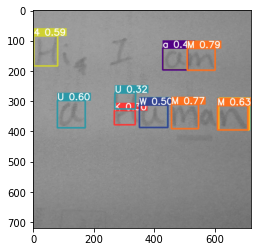

In [ ]:
# random.seed()
%matplotlib inline

detections_dir = "/content/drive/MyDrive/OCR Project(SMU)/emnist_coloured_20k/yolo_emnist_detect_det_real8"
detection_images = [os.path.join(detections_dir, file) for file in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))